### 导入模块与库
* 程序操作\文件路径管理等模块
* 数据处理\科学计算\数组等模块
* 绘图工具

In [117]:
from pathlib import Path
import sh
import re
import time

import georinex as grnx
import netCDF4 as nc
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
import scipy.constants as const
import astropy.constants as astro_const
import pyproj
import ppigrf as IGRF13
import iri2016 as IRI2016
import aacgmv2
import scipy.io as scio
import xarray as xr

from pylab import *
from matplotlib.pyplot import figure, show
import matplotlib.pylab as plt


### 常规工作
#### is_Command_sh 程序检查
* runpkr00
* teqc
* gfzrnx

In [2]:
def is_Commands_sh(Command = 'runpkr00'):
    try:
        if( Command == 'runpkr00'):
            sh.runpkr00()
        if( Command == 'teqc'):
            sh.teqc('+help')
        if( Command == 'gfzrnx'):
            sh.gfzrnx('-help')
    except sh.ErrorReturnCode as e: 
        print(f'Command {e.full_cmd} exited with {e.exit_code}')

# is_Commands_sh( cmd )    # test

#### startTiming endTiming 计时器

In [3]:
# timer

def startTiming( process_description = 'process' ):
    
    global startTIME
    
    startTIME = time.perf_counter()
    timing = time.strftime("%Y-%m-%d  %H:%M:%S", time.localtime())
    
    print(f'{process_description} starts at: {timing} ')
    
def endTiming( process_description = 'process' ):
    
    global endTIME
    
    endTIME = time.perf_counter()
    timing = time.strftime("%Y-%m-%d  %H:%M:%S", time.localtime())
    costTIME = globals()['endTIME'] - globals()['startTIME']
    
    print(f'{process_description}   ends at: {timing} \n'
          f'{process_description}   costs  : {costTIME/60.0 :7f} min in total ')

### 存储路径与文件准备
#### mkdir_for_scrdir
#### new_obs_info_txt

In [4]:
def mkdir_for_srcdir(source_dir, file_dir):
    dirs = {}
    for fdir in file_dir:
        data_dir = Path(f'{source_dir}/{fdir}')
        data_dir.mkdir(mode = 0o777, 
                        parents = True, 
                        exist_ok = True)
        dirs[fdir] = data_dir
    return dirs

# data_dir = mkdir_for_srcdir(src_dir, ['TGD','RNX','TEC'])    test

def new_obs_info_txt(source_dir = Path( '/home/echoo/data/GNSS' ) ,
                     file_list = ['qcinfo', 'RNX_update', 'RNX_rename', 'RNX_elevation'], 
                     file_type = 'txt'):
    info_file = {}
    
    for file in file_list:
        file_path = Path(f'{source_dir}/{file}.{file_type}')
        
        if not Path.is_file(file_path):
            file_path.touch()
            
        info_file[file] = file_path
    return info_file

# info_path = new_obs_info_txt( src_dir.parent, ['qcinfo',
#                                                'RNX_update',
#                                                'RNX_rename', 
#                                                'RNX_version',] )    # test
# info_path    # test

#### delete_file_in_dir

In [5]:
def delete_file_in_dir( file_to_del_dir ):
    for file_to_del in file_to_del_dir.glob('**/*'):
        if  Path.is_file(file_to_del):
            file_to_del.unlink()
# is_Command_sh('teqc')    #test

### 数据格式转换
#### convert_TrimbleT02toTGD_runpkr00
将天宝接收器T02数据文件转换为二进制数据文件TGD

In [6]:
def convert_TrimbleT02toTGD_runpkr00(hours = {'00':'00'}, 
                                     T02_srcdir = Path( '/home/echoo/data/GNSS/266' ), 
                                     TGD_srcdir = Path( '/home/echoo/data/GNSS/266/TGD' )
                                    ):
    descrip = 'runpkr00 - trimble T02 converting to TGD binary'
    
    startTiming( descrip )
    
    delete_file_in_dir( TGD_srcdir )
    
    mkdir_for_srcdir(TGD_srcdir, hours.keys())
    
    for obs_hour in hours.keys():
        
        T02_dir = Path( f'{T02_srcdir}/{obs_hour}' )
        TGD_dir = Path( f'{TGD_srcdir}/{obs_hour}')
        
        for count, T02_file in enumerate( T02_dir.glob('*.t02'), start = 1 ):
            if  count%4 == 1:
                sequence = (count+3)//4
                print(f'\n  {obs_hour} - {(count+3)//4:3d} - {descrip}: ')
                
            try:
                sh.runpkr00( '-d', '-g', T02_file, TGD_dir )  
            except sh.ErrorReturnCode as e:
                print(f'           - {T02_file.stem}: '
                      f'converting exited with {e.exit_code}. ' )
            else:
                print(f'           - {T02_file.stem}: '
                      f'converted successfully.  ' )
        print(f'\n  {(count+3)//4:3d} - {descrip} '
              f'T02 data of {obs_hour}th hour processed \n' )
    endTiming( descrip )
                        
# convert_TrimbleT02toTGD_runpkr00( obs['hour'], src_dir, data_dir['TGD'] )    #test
#     runpkr00 - trimble T02 converting to TGD binary   costs  : 38.361892 min in total

# convert_TrimbleT02toTGD_runpkr00( obs['hour'] )    #test

#### cal_obs_ecef_position_teqc
* teqc: 对TGD文件使用质量核检功能qc计算出站点静地坐标
* 存入文本文件以供后期GFZRNX转换RNX文件时填充站点位置信息

In [7]:
def cal_obs_ecef_position_teqc(TGD_dir = Path( '/home/echoo/data/GNSS/272/TGD' ),
                               qcinfo_file = Path('/home/echoo/data/GNSS/qcinfo.txt'), 
                               update_file = Path('/home/echoo/data/GNSS/RNX_update.txt'), 
                               rename_file = Path('/home/echoo/data/GNSS/RNX_rename.txt')
                              ):
    
    descrip = 'teqc - calculate obs_ecef position'
    
    startTiming( descrip )
    
    with open( update_file, 'w' ) as f_RNXupdate:
        f_RNXupdate.write(f'update_insert:\n'
                          f'#-------------\n'
                          f'  O - ALL:\n'
                          f'    "OBSERVER / AGENCY": {{ '
                          f'0 : "GNSS Observer", '
                          f'1 : "Trimble" }}\n'
                          f'\n'
                          f'  N - ALL:\n'
                          f'    "LEAP SECONDS": {{ 0 : "4" }}\n')
        
    with open( rename_file, 'w' ) as f_RNXrename:
        f_RNXrename.write(f'rename: obs\n'
                          f'#-------------\n'
                          f'  C1 - C2I - C : ALL\n'
                          f'  C6 - C6I - C : ALL\n'
                          f'  C7 - C7I - C : ALL\n'
                          f'  L1 - L2I - C : ALL\n'
                          f'  L6 - L6I - C : ALL\n'
                          f'  L7 - L7I - C : ALL\n')
#     sh.cd(src_dir)    
    for count, TGD_file in enumerate( TGD_dir.rglob( '**/*d00.tgd' ),start = 1 ):
        try:
            sh.teqc('+qc', 
                    '+dm', '3',
                    '+C1-5', 
                    '-no_orbit', 'G+S+E+J+I',
                    '-rep', 
#                     '+plot', '-ion', '-iod', '-mp', '-sn',
                    TGD_file ,_out = qcinfo_file )
        except sh.ErrorReturnCode as e:
            print(f'      {descrip} - {TGD_file.stem}: '
                  f'      exited with {e.exit_code}. \n' )
        else:
            print(f'        - {TGD_file.stem}: '
                  f'quality check successfully.  ' ) 
        
        with open( qcinfo_file ,'r' ) as f_qcinfo:
            for line in f_qcinfo:
                regex = re.compile( r'4-character ID' )

                if re.search( regex,line ):
                    obs_name = line.split( ':' )[1].split( '(' )[0]

                    with open( update_file, 'a' ) as f_RNXupdate:
                        f_RNXupdate.write( f'\n  O - {obs_name}:\n' )

                regex = re.compile( r'antenna WGS 84 [(]xyz[)]' )

                if re.search( regex,line ):
                    obs_posi = line.split( ':' )[1].split( '(' )[0].split( ' ' )
                    
                    with open( update_file, 'a' ) as f_RNXupdate:
                        f_RNXupdate.write(f'    "APPROX POSITION XYZ": '
                                          f'{{ 0: {obs_posi[1]}, '
                                          f'1: {obs_posi[2]}, '
                                          f'2: {obs_posi[3]} }}\n' )
                    
                    print(f'   {count:4d} - {descrip}: \n'
                          f'         {obs_name}- WGS84 xyz: {obs_posi[1:4]} .\n' )

                    break
#         with open( f'{TGD_file.stem}.ele' ,'r' ) as f_eleinfo:
#             for count,line in enumerate(f_eleinfo, start = 1):
#                 if count == 3:
#                     sv_name = line.split( ' ' )[-5:]
#                 if count == 4:
#                     sv_ele  = line.split('    ')[-5:]
#                     with open(ele_file, 'a') as f_ele:
#                         f_ele.write(f'sv       : {sv_name}\n'
#                                     f'elevation: {sv_ele}\n'
#                                    )
#                     break

    endTiming( descrip )


# cal_obs_ecef_position_teqc()   # test
#     teqc - calculate obs_ecef position   costs  : 26.422665 min in total

#### convert_TGDtoRNX2_teqc
* teqc: 将TGD文件转换为RINEX2格式文件

In [8]:
def convert_TGDtoRNX2_teqc(obs_year = '23', 
                           obs_doy = '262', 
                           hours = {'00':'00'}, 
                           TGD_srcdir = Path( '/home/echoo/data/GNSS/272/TGD' ), 
                           RNX_srcdir = Path( '/home/echoo/data/GNSS/272/RNX' )):
    
    descrip = 'teqc: convert TGD to RINEX2 observation file '
    
    startTiming( descrip )
    
#     delete_file_in_dir( RNX_srcdir )
    
    mkdir_for_srcdir( RNX_srcdir, hours.keys() )
    
    for obs_hour in hours.keys():
        
        TGD_dir = Path( f'{TGD_srcdir}/{obs_hour}' )
        
#         if not Path.is_dir(TGD_dir):
#             continue
        
        RNX_dir = Path( f'{RNX_srcdir}/{obs_hour}' )
        
#         if not Path.is_dir(RNX_dir):
#             continue
        
        count = 1
        for count, TGD_file in enumerate( TGD_dir.glob('*.tgd'), start = 1 ):
            
            if  count%4 == 1:
                print(f'\n  {obs_hour} - {(count+3)//4:3d} - {descrip}')
                
            file_name = TGD_file.stem
            
            NAV2_file = Path(f'{RNX_dir}/{file_name}.{obs_year}c')
            RNX2_file = Path(f'{RNX_dir}/{file_name}.{obs_year}o')
            
            try:
                sh.teqc('-week', f'20{obs_year}/{obs_doy}', '-tr', 'd', \
                    '+C1-5', '-G', '-R', '-S', '-E', '-J', '-I', \
                    '+P', '+C2', '+L2', '+L1_2', '+L2_2', '+CA_L1', '+L2C_L2', \
                    '-SA_G1', '-SA_G2', \
                    '-L5', '+L6', '+L7', '-L8', \
                    '+relax', \
#                     '+nav', f'-,-,-,-,{NAV2_file},-', \
                    TGD_file ,\
                    _out = RNX2_file )
                
                TGD_file.unlink()    
            except sh.ErrorReturnCode as e:
                print(f'           - {TGD_file.stem}: '
                      f'converting exited with {e.exit_code}. ' )
            else:
                print(f'           - {TGD_file.stem}: '
                      f'converted successfully.  ' )
                
            try:
                sh.teqc('+v', f'{RNX2_file}')
            except sh.ErrorReturnCode as e:
                RNX2_file.unlink()
                print(f'           - {RNX2_file.stem}: '
                      f'RNX format is wrong with {e.exit_code}, DELETED. ' )
                
        print(f'\n  {count//4+1:3d} - {descrip} '
              f'of {obs_hour}th hour processed. \n' )
        
        delete_file_in_dir(TGD_dir)
        TGD_dir.rmdir()
        
    endTiming( descrip )

# convert_TGDtoRNX2_teqc(obs['year'], 
#                        obs['doy'], 
#                        obs['hour'], 
#                        data_dir['TGD'], 
#                        data_dir['RNX'])    # test           
#     teqc: convert TGD to RINEX2 observation file    costs  : 14.356636 min in total 


#### convert_RNX2toRNX3_gfzrnx
* 将RINEX2转换为RINEX3格式
* 实际使用过程中, georinex对RINEX3的读取并不友好, 对由teqc转换后的RINEX2读取也不行, 这里实际是将teqc的RINEX2文件进行纠正后, kv选项保持原版本, 也就是说输出仍为RINEX2格式, 但是能够被georinex.load()方法读取
* 命名风格为RINEX3是为了与teqc转换处的RINEX2文件(o文件)进行区分, 数据存储方式实际为RINEX格式

In [9]:
def convert_RNX2toRNX3_gfzrnx(obs_year = '23',
                              obs_doy = '262',
                              obs_hours = {'00':'00','01':'01'}, 
                              RNX_scrdir = Path( '/home/echoo/data/GNSS/271/RNX' ), 
                              update_file = Path('/home/echoo/data/GNSS/RNX_update'), 
                              rename_file = Path('/home/echoo/data/GNSS/RNX_rename'), 
                              RNX_type = 'obs'):
    
    descrip = f'\n gfzrnx - {RNX_type} : convert RINEX2 to RINEX3 '
    
    startTiming( descrip )
    
    RNX_suffix = ('o' if RNX_type == 'obs' else 'c')
    
    obs_names = {RNX2_file.stem[0:4]:RNX2_file.stem[0:4]
                for RNX2_file in RNX_scrdir.glob(f'**/*.{obs_year}{RNX_suffix}')}
    
    count_successed = 0
    count_failed    = 0
    for count, obs_name in enumerate(obs_names.values(), start = 1):
        
        RNX2_file = [f'{RNX_scrdir}/{obs_hour}/{obs_name}*.{obs_year}{RNX_suffix}'
                     for obs_hour in obs_hours.keys()]
#         print(RNX2_file)
        try:
            sh.gfzrnx('-finp', 
                      RNX2_file, 
                      '-f','-chk',  
#                       '-vo', '3', 
                      '-obs_types', 'L,P,C',
                      '-crux', update_file,  
                      '-kv',      
                      '-fout', f'{RNX_scrdir}/::RX3::CHN' )
#                       '-fout', f'{RNX_scrdir}/::RX2::CHN' )
            
        except sh.ErrorReturnCode as e:
#             print(e)
            
            count_failed   += 1
            print(f'\n    {count:3d} - {RNX_type} - {obs_name}  : '
                  f'converting exited with {e.exit_code}. ' )
        else:
            
            count_successed += 1
            print(f'\n    {count:3d} - {RNX_type} - {obs_name}  : '
                  f'converted successfully.  ' )
            
            for file_to_del in RNX_scrdir.rglob(f'**/{obs_name}*.{obs_year}{RNX_suffix}'):
                if(Path.is_file(file_to_del)):
                    file_to_del.unlink()
    print(f'\n    {count_successed} sessions successed, '
          f'{count_failed} sessions failed')        
    endTiming( descrip )

# convert_RNX2toRNX3_gfzrnx(obs['year'], 
#                           obs['doy'],
#                           obs['hour'], 
#                           data_dir['RNX'], 
#                           info_path['RNX_update'], 
#                           info_path['RNX_rename'], 
#                           'obs')    # test
# gfzrnx - obs : convert RINEX2 to RINEX3    costs  : 121.619125 min in total

# convert_RNX2toRNX3_gfzrnx(obs['year'], 
#                           obs['doy'],
#                           obs['hour'], 
#                           data_dir['RNX'], 
#                           info_path['RNX_update'], 
#                           info_path['RNX_rename'], 
#                           'nav')    # test
# # gfzrnx - nav : convert RINEX2 to RINEX3    costs  : 4.557254 min in total
# convert_RNX2toRNX3_gfzrnx()

### TEC数据解算
#### cal_sTEC_Hatch_filter
* 基于双频观测组合TEC解算原理
* 使用相位平滑伪距TEC (消除多径效应)
* 输出伪距TEC 相位TEC 相位平滑伪距TEC

In [10]:
def cal_sTEC_Hatch_filter(freqc_1 = 1561.098 * const.mega,
                          freqc_2 = 1207.14  * const.mega,
                          Pseudo_range_1 = 37242344.055, 
                          Pseudo_range_2 = 37242345.625, 
                          Carrier_phase_1 = 193930606.992, 
                          Carrier_phase_2 = 149959487.782, 
                          win_size = 180):
    
#     descrip    = f' calculate Hatch-filtered sTEC'
    
#     startTiming( descrip )
    
    TECU       = 1.00E16
    sample_period = 1.0
    coef       = const.e**2 / ( 8*const.pi**2 *const.epsilon_0*const.electron_mass) * TECU
    coeff      = 1 / coef * (freqc_1*freqc_2)**2/(freqc_1**2 - freqc_2**2) 
    gamma      = (freqc_1 / freqc_2)**2
    
    wavelen_1  = const.speed_of_light / freqc_1
    wavelen_2  = const.speed_of_light / freqc_2
#     wavelen_WL = const.speed_of_light / (freqc_1 - freqc_2)
    
    dPseudo    = Pseudo_range_1 - Pseudo_range_2
    dPhase     = Carrier_phase_1*wavelen_1 - Carrier_phase_2*wavelen_2
#     Nambig_WL  = Carrier_phase_1 - Carrier_phase_2 - \
#                  ( freqc_1*Pseudo_range_1 + freqc_2*Pseudo_range_2) / (wavelen_WL * (freqc_1 + freqc_2))
#     if abs(dNambig_WL[k-1]-dNambig_WL[k]) > 1, cycle slip happened    
    
    sTEC_pseudo = - coeff * dPseudo 
    sTEC_phase  =   coeff * dPhase 
    
    sTEC_rate   = np.hstack((0, np.array(sTEC_phase[1:]) - np.array(sTEC_phase[:-1]))) / sample_period
    
    if(len(dPhase)<40):
        warning = 'lacking data supporting length'
        return warning
    
    
    
    for index in range(32,len(dPhase)):
        sTEC_rate[index-1] = sTEC_rate[(index-1-30):(index-1)].mean()
        sTEC_rate[index-2] = sTEC_rate[(index-2-30):(index-2)].mean()
        d_sTEC_rate   = sTEC_rate[index-1]-sTEC_rate[index-2]
        est_sTEC_rate = sTEC_rate[index-1]+d_sTEC_rate
        if abs(sTEC_rate[index] - est_sTEC_rate) > 0.15:
#             print(index)
#             print(sTEC_rate[index])
#             print(est_sTEC_rate)
            cycle_slip = coef*(gamma-1)*sample_period*est_sTEC_rate/freqc_1**2-dPhase[index]+dPhase[index-1]
            sTEC_rate[index] = est_sTEC_rate
            dPhase[index:] = dPhase[index:] + cycle_slip
            
        
    sTEC_phase  =   coeff * dPhase
    
    
    dP         = np.hstack( (dPseudo, dPseudo[-1*win_size:-1]) )
    dL         = np.hstack( (dPhase , dPhase[-1*win_size:-1] ) )
               
    dP_averged = np.convolve(dP ,np.ones(win_size),'valid')/(win_size*1.0)
    dL_averged = np.convolve(dL ,np.ones(win_size),'valid')/(win_size*1.0)
    dP_smthed  = dP_averged + dL_averged - dPhase
    
    
    sTEC_smthed = - coeff * dP_smthed
    
#     endTiming( descrip )
    
    return sTEC_pseudo, sTEC_phase, sTEC_smthed


# RNX_file = Path('/home/echoo/data/GNSS/218/RNX/AHBB00CHN_R_20232180000_01D_01S_CO.rnx')
# oVar        = grnx.load(RNX_file, fast = False)

# # obs_name    = RNX_file.stem[0:4]
# # sample_rate = oVar.interval   
# # time_system = oVar.time_system
# # rxmodel     = oVar.rxmodel 

# sTEC_pseudo, sTEC_phase, sTEC_smthed = cal_TECs_of_svs(oVar,
#                         'C04',
#                         freqc
#                        )

# plot_TECs_at_station('AHBB repaird TEC_phase',
#                      'C04',
#                      sTEC_pseudo[20770:20830],
#                      sTEC_phase[20770:20830],
#                      sTEC_smthed[20770:20830],
#                      sTEC_smthed[20770:20830], 
#                      65)

#### lla2ecef ecef2lla
* 在地理坐标系lla(longitude,latitude,altitude)和地心地固空间坐标系(ecef:x,y,z)之间相互转换
* 基于 WGS 84 地理坐标系统

In [11]:
def lla2ecef(lon, lat, alt):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(lla,ecef,always_xy = True)
    return transformer.transform(lon,lat,alt,radians = False)

def ecef2lla(x, y, z):
    lla = {"proj":'latlong', "ellps":'WGS84', "datum":'WGS84'}
    ecef = {"proj":'geocent', "ellps":'WGS84', "datum":'WGS84'}
    transformer = pyproj.Transformer.from_crs(ecef,lla,always_xy = True)
    return transformer.transform(x,y,z,radians = False)

#### project_sTEC_to_vTEC
* 根据GNSS站点位置与卫星位置,计算出穿刺点位置和卫星在穿刺点处的天顶角
* 电离层薄壳假设
* 假定电离层高度为350km

In [12]:
def project_sTEC_to_vTEC(obs_ecef = [-2457371.4562, 4763952.4528, 3444706.7760],
                         sat_lla = [140, 1.5, ], 
                         H_orbit = 35786 * const.kilo, 
                         H_ionosphere = 400 * const.kilo
                        ):
    
    surface_ecef_obs = np.array([obs_ecef[0], obs_ecef[1], 0])
    R_earth          = np.sqrt(np.dot(surface_ecef_obs,surface_ecef_obs) )
    
    X_obs, Y_obs, Z_obs = obs_ecef
    obs_ecef            = np.array([X_obs, Y_obs, Z_obs])
    
    lon_sat, lat_sat, alti_sat = sat_lla
    X_sat, Y_sat, Z_sat        = lla2ecef(lon_sat, lat_sat, alti_sat)
    sat_ecef                   = np.array([X_sat, Y_sat, Z_sat])
    
    R_obs                      = np.sqrt(np.dot(obs_ecef,obs_ecef))
    Evector_obs                = 1.0/ R_obs * obs_ecef     # cannot devid by zero
    
    obs2sat_ecef               = sat_ecef - obs_ecef
    
    Range_obs2sat              = np.sqrt(np.dot(obs2sat_ecef,obs2sat_ecef))
    Evector_obs2sat            = 1.0/Range_obs2sat * obs2sat_ecef
    
    zenith_obs                 = np.arccos( np.dot(Evector_obs, Evector_obs2sat) )
    zenith_IPP                 = np.arcsin( R_earth / (R_earth + H_ionosphere) * np.sin(zenith_obs) )
    
#     print('elevation at obs: ', (const.pi/2-zenith_obs)/const.pi*180)
#     print('elevation at IPP: ', (const.pi/2-zenith_IPP)/const.pi*180)
    Delta         = zenith_obs - zenith_IPP
    
    range_obs2IPP = R_earth * np.sin(Delta) / np.sin(zenith_IPP)
    
    IPP_ecef      = np.array(obs_ecef + range_obs2IPP * Evector_obs2sat)
    
    IPP_lla       = ecef2lla(IPP_ecef[0],IPP_ecef[1],IPP_ecef[2])
    
    return zenith_IPP, IPP_lla

# zenith_IPP, IPP_lla = project_sTEC_to_vTEC(obs.position, 
#                                            C01_position,
#                                            H_orbit)   # test

# vTEC_smthed = sTEC_smthed * cos(zenith_IPP)    # test

### TEC数据存储为nc文件
#### cal_TECs_of_svs
* 根据不同卫星信号的观测值计算TEC

In [155]:
def cal_TECs_of_svs(obs,
                    prn, 
                    freqc):
    
    print(f'\n      BDS - {prn:3} : calculate combination TEC starts:\n')
    
    combination = 'E2_E5b_I'
    try:
        C2I = obs['C1'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        C7I = obs['C7'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        L2I = obs['L1'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        L7I = obs['L7'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        
        sTECs = cal_sTEC_Hatch_filter(freqc['E2I'],
                                      freqc['E5bI'],
                                      C2I,
                                      C7I, 
                                      L2I,
                                      L7I,
                                      3600)
        
        sTEC_pseudo, sTEC_phase, sTEC_smthed = sTECs
        
    except:
        del C2I, C7I, L2I, L7I
        print(f'      BDS - {prn:3} : frequency {combination} combination TEC failed. \n')
    else: 
        print(f'      BDS - {prn:3} : frequency {combination} I combination TEC successfuly. \n')
        
        return sTECs, combination
    
    combination = 'E2_E6_I'
    try:
        C2I = obs['C1'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        C6I = obs['C6'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        L2I = obs['L1'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        L6I = obs['L6'].sel(sv = prn).dropna(dim = 'time', how = 'all')
        
        sTECs = cal_sTEC_Hatch_filter(freqc['E2I'],
                                      freqc['E6I'],
                                      C2I,
                                      C6I, 
                                      L2I,
                                      L6I,
                                      3600)
        sTEC_pseudo, sTEC_phase, sTEC_smthed = sTECs
        
    except:
        del C2I, C6I, L2I, L6I
        print(f'      BDS - {prn:3} : frequency {combination} combination TEC failed\n'
              f'\n'
              f'      BDS - {prn:3} : calculate combination TEC failed\n')
        return False
    else:
        
        print(f'      BDS - {prn:3} : frequency {combination} I combination TEC successfuly\n')
        
        return sTECs, combination
    
# sTECs, vTECs = cal_TECs_of_svs(obs,
#                                prn, 
#                                freqc,
#                                IPP_zenith, 
#                                IPP_lla)    # test
# # sTECs[1]

#### cal_sysm_DCBs_of_station
* 解算GNSS系统硬件延迟 (频间偏差)

In [336]:
def cal_sysm_DCBs_of_station(TEC_observer          ,
                             OBSposition           ,
                             step         = 45     ,
                             Hionos       = 400000 ,
                             save_dir     = '/home/echoo/echoo/mycode/PLOT'
                            ):
    
    description = 'calculate the SPR DCBs of observing station...'
    observer    = TEC_observer.observer.values[0]
    time        = TEC_observer.time
    
    print(f'     {observer} - {description}')
    
    OBSx  , OBSy  , OBSz    = OBSposition
    OBSlon, OBSlat, OBSalt  = ecef2lla(OBSx  , OBSy  , OBSz)
    OBSalt                 /= 1000.0
    Hionosphere             = Hionos / 1000.0
    
    svs_total = TEC_observer.sv.count()
    dropped   = 0
    svs       = TEC_observer.sv.data.tolist()

    matr_posi = {}
    matr_sTEC = {}
    
    is_first_svN = True
    
    for svN in svs:
        
            
        svN    = [svN]
        sTEC   = TEC_observer.sTEC_smth.sel(sv = svN)[0][0].dropna(dim = 'time').values
        zenith = TEC_observer.zenith.sel(sv = svN).values[0]    
        
        if  (svs_total - dropped) > 3 and (zenith > const.pi/3.0):
            dropped += 1
            continue
            
        L      = len(sTEC)

        IPPlon = TEC_observer.lon.sel(sv = svN)[0][0].values
        IPPlat = TEC_observer.lat.sel(sv = svN)[0][0].values

        svn    = svN[0]
        span   = np.arange(0,L,step)

        
        matr_sTEC[svn] = sTEC[span] 
        time_span      = time[span]

        IPP_mLat       = np.zeros(time_span.shape)
        IPP_tLocal     = np.zeros(time_span.shape)
        OBS_mLat       = np.zeros(time_span.shape)
        DCB_insert     = np.zeros(time_span.shape) + 1

        for i, t in enumerate(time_span):

            dtime  = t.values.astype('str')
            dtime  = dt.strptime(dtime, '%Y-%m-%dT%H:%M:%S.000000000')

            IPPmlat, IPPmlon, IPPmlct = aacgmv2.get_aacgm_coord_arr(IPPlat, IPPlon, Hionosphere, dtime,
                                                                    method = 'ALLOWTRACE')
            
            OBSalt = 1.0 if OBSalt < 0 else OBSalt
            
            OBSmlat, OBSmlon, OBSmlct = aacgmv2.get_aacgm_coord_arr(OBSlat, OBSlon, OBSalt     , dtime,
                                                                    method = 'ALLOWTRACE')

            IPP_mLat[i]   = IPPmlat[0]
            OBS_mLat[i]   = OBSmlat[0]
            IPP_tLocal[i] = IPPmlct[0]
            
        phi_dif        = np.radians(IPP_mLat - OBS_mLat)
        lambdsolar     = 2 * const.pi * (IPP_tLocal - 14.0) / 24.0
        
        del IPP_mLat, OBS_mLat, IPP_tLocal

        matr_posi[svn] = np.vstack((lambdsolar**0          , lambdsolar**1         ,lambdsolar **2           ,
                                    lambdsolar * phi_dif   , 
                                    np.cos(1 * lambdsolar) , np.cos(2 * lambdsolar), np.cos(3 * lambdsolar)  ,
                                    np.cos(4 * lambdsolar) , np.cos(5 * lambdsolar), np.cos(6 * lambdsolar)  ,
                                    np.sin(1 * lambdsolar) , np.sin(2 * lambdsolar), np.sin(3 * lambdsolar)  ,
                                    np.sin(4 * lambdsolar) , np.sin(5 * lambdsolar), np.sin(6 * lambdsolar)
                                   ))

        matr_posi[svn] = matr_posi[svn] / np.cos(zenith)

        matr_posi[svn] = np.vstack((matr_posi[svn], 
                                    DCB_insert
                                   ))
        
        matr_X = matr_posi[svn] if is_first_svN else \
                 np.hstack((matr_X, matr_posi[svn]))
        
        matr_Y = matr_sTEC[svn] if is_first_svN else \
                 np.hstack((matr_Y, matr_sTEC[svn]))
        
        is_first_svN = False 
    
    matr_X_T = np.dot( matr_X, matr_X.T )
    
    del matr_posi, matr_sTEC
    
    if  np.linalg.det(matr_X_T) == 0 :
        print('     The matrix is singular, cannot do inverse!')
        return None
    
    loops = svs_total - dropped
    
    if  loops < 3:
        print(f'     WARNING : the number of satellite in calculation is {loops} (less than 3), \
                             results may be NOT in accurency...')
        
    result          = np.linalg.solve(matr_X_T, np.dot(matr_X, matr_Y.T))
    
    regression_coef = result[ :-1]
    DCBs            = result[  -1]
    
    del matr_X_T, result
    
    sTEC_fitted     = np.dot(regression_coef, matr_X[:-1, :])
    sTEC_est        = matr_Y - DCBs
    
    del regression_coef, matr_X
    
    theday = dtime.strftime('%Y-%m-%d')
    
    figure()
    plt.plot(matr_Y                     ,
             color     = 'lightblue'    ,
             marker    = ','            , 
             linestyle = ""             ,
             label     = 'STECsmth_observed'
            )
    plt.plot(sTEC_est                   , 
             color     = 'c'            ,
             marker    = ','            , 
             linestyle = ""             ,
             label     = 'STECsmth_corrected'
            )
    plt.plot(sTEC_fitted                ,
             color     = 'grey'         , 
             marker    = ','            , 
             linestyle = ""             ,
             label     = 'STECsmth_estimated'
            )
    
    plt.title(f'{observer} - {theday}  DCBs correction')
    
    legend(labelcolor = 'linecolor')

    plt.savefig(f'{save_dir}/sTEC_{observer}_{theday}.png',
                bbox_inches='tight'
               )
    show()
    
    return DCBs

# DCBs = cal_sysm_DCBs_of_station(TEC_observer = TEC_obser    ,
#                                  OBSposition  = oVar.position,
#                                  step         = 45           ,
#                                  Hionosphere  = H_ionos      ,
#                                  combination  = combination
#                                 ) # test
# DCBs  

#### struct_TECs_of_stations
* 结构化TEC数据为Dataset

In [353]:
def struct_TECs_of_stations(sTECs      , 
                            lon        , lat        , zenith, 
                            obs_name   , prn        , 
                            sample_rate, time_system, rxmodel, combination):
    
    sTEC_pseudo,sTEC_phase,sTEC_smthed = sTECs
    del sTECs

    times = sTEC_smthed.time.values

    lon = IPP_lla[prn][0]
    lat = IPP_lla[prn][1]

#     sTEC_pha  =  sTEC_phase.values.reshape(1, 1, -1)
    sTEC_smth = sTEC_smthed.values.reshape(1, 1, -1)

    del sTEC_pseudo, sTEC_phase, sTEC_smthed
    
    TEC_dict = {'dims':{'observer':size([obs_name]), 
                        'sv'      :size([prn]), 
                        'time'    :size(times)
                       },
                
                'coords':{'observer':{'dims' : ('observer', ), 
                                      'attrs': {'standard_name': 'observation_station' }, 
                                      'data' : [obs_name] 
                                     },
                          
                          'sv'      :{'dims' : ('sv', ), 
                                      'attrs': {'standard_name': 'satellite_prn'}, 
                                      'data' : [prn] 
                                     },
                          'time'    :{'dims' : ('time',), 
                                      'attrs': {'standard_name': 'time'}, 
                                      'data' : times 
                                     },
                          'lon'     :{'dims' : ('observer', 'sv'), 
                                      'attrs': {'standard_name': 'longitude', 
                                                'units': 'degrees_east', 
                                                'axis': 'X' 
                                               }, 
                                      'data' : [[lon]] 
                                     },
                          'lat'     :{'dims' : ('observer', 'sv'), 
                                      'attrs': {'standard_name': 'latitude', 
                                                'units': 'degrees_north', 
                                                'axis': 'Y' 
                                               }, 
                                      'data': [[lat]] 
                                     }, 
                         },
                
                'data_vars':{'sTEC_smth': {'dims' : ('observer' , 'sv', 'time'), 
                                           'attrs': {'long_name': 'Total Electron Content ', 
                                                     'units'    : 'TECU', 
                                                     'var_desc' : 'bi_frequency slant TEC', 
                                                     'smth_type': 'Carrier_phase smoothing Pseudo_range TEC ' 
                                                    }, 
                                           'data': sTEC_smth 
                                          },
                             
                             'zenith'   :{'dims' : ('observer' , 'sv'), 
                                          'attrs': {'long_name': 'satelltite zenith to IPP', 
                                                    'units'    : 'rad' 
                                                   }, 
                                          'data' : [[zenith]] 
                                         },
#                              'DCBs'     :{'dims' : ('observer',), 
#                                           'attrs': {'long_name': 'Differential Code Bias', 
#                                                     'units'    : 'TECU', 
#                                                     'system'   : 'SPR (satellite plus receiver)', 
#                                                     'fillvalue': '0.00' 
#                                                    }, 
#                                           'data' : [0.00] 
#                                          } 
                            }, 
                
                'attrs':{'sample_rate': sample_rate,
                         'Geo_sysm'   : 'WGS 84',
                         'time_sysm'  : time_system,
                         'rxmodel'    : rxmodel,
                         'combination': combination
                        } 
               }
    TEC = xr.Dataset.from_dict(TEC_dict)
    

    del  sTEC_smth
    return TEC

### 数据检验
#### plot_TECs_at_station
* 进行绘图直观判断数据质量以及程序是否正常工作

In [15]:
# period = 86400    # test
def plot_TECs_at_station(obs_name, 
                          prn,
                          sTEC_pseu, 
                          sTEC_phas, 
                          sTEC_smth, 
                          vTEC_smth, 
                          View_size):
    ax = figure().gca()
    
    ax.plot(sTEC_pseu[0:View_size], color = 'lightblue',marker = ',',linestyle = "", label = 'sTEC_pseudo')
    ax.plot(sTEC_phas[0:View_size],color = 'c',marker = ',',linestyle = "", label = 'sTEC_phase')
    ax.plot(sTEC_smth[0:View_size],color = 'black',marker = ',',linestyle = "", label = 'sTEC_smoothed')
    ax.plot(vTEC_smth[0:View_size],color = 'grey',marker = ',',linestyle = "", label = 'vTEC_smoothed')
    
    legend(labelcolor = 'linecolor')
    
    plt.xlabel('time / second')
    plt.ylabel('TEC / TECU')
    
    plt.title(f'23/09/19 (UTC)  {obs_name} {prn}')
    
    show()

# plot_TECs_at_station(sTEC_pseudo, 
#                       sTEC_phase, 
#                       sTEC_smthed, 
#                       vTEC_smthed, 
#                       period)    # test

#### compare_TEC_phase_with_Sample
* 将相位TEC计算结果与Matlab计算结果进行比较

In [16]:
def compare_TEC_phase_with_Sample(to_test,
                                  to_refer):
    ax = figure().gca()
    # ax.plot(TEC.time, TEC)
    # ax.plot(TEC1.time, TEC1)
    # ax.plot(to_test)
    ax.plot(to_refer, 'k:', label = 'Matlab: sTEC_phase')
    ax.plot(to_test, 'c:', label = 'Python: sTEC_phase')

    legend(labelcolor = 'linecolor')

    plt.xlabel('time / second')
    plt.ylabel('TEC / TECU')

    plt.title('23/09/19(UTC) AHBB C01')

    show()

# compare_TEC_phase_with_Sample(test_set, sample)    # test

### main
#### 参数初始化
* 观测日期\站点信息
* 定义数据存储路径
* 卫星信号频率\位置坐标

In [17]:
# test

# cmd = 'gfzrnx'
# is_Commands_sh( cmd )    # test

# argument and datapath
obs = {}

obs['date'    ]    = datetime.date(year = 2023, 
                                   month = 9, 
                                   day = 23 )
obs['interval']    = 15

obs['sample_rate'] = '01s'

obs['year'    ]    = obs['date'].strftime("%y") 
obs['doy'     ]    = obs['date'].strftime("%j") 

obs['hour'    ]    = {f'{key:02}':chr(key+97) 
                      for key in range(0,24)}

obs['minute'   ]   = {f'{key:02}':f'{key:02}' 
                      for key in range(0,60,obs['interval'])}

obs['doy'] = '215'   #test /run/media/echoo/TOSHIBA EXT/210

src_dir = Path(f"/run/media/echoo/TOSHIBA EXT/{obs['doy']}")

data_dir = mkdir_for_srcdir(src_dir, ['TGD','RNX','TEC','PLOT'])

info_path = new_obs_info_txt( src_dir.parent, ['qcinfo',
                                               'RNX_update',
                                               'RNX_rename'] )

freqc = {'E2I' :1561.098 * const.mega, 
         'E6I' :1268.52  * const.mega, 
         'E5bI':1207.14  * const.mega }

#     C01 - 地球静止轨道140.0°E，高度35807×35782公里，倾角1.6°
#     C02 - 地球静止轨道84.07°E，高度35803×35783公里，倾角1.7°
#     C03 - 地球静止轨道110.45°E，高度35854.3×35885.9公里，倾角1.7°
#     C04 - 地球静止轨道159.98°E，高度35815×35772公里，倾角0.6°
#     C05 - 地球静止轨道58.71°E，高度35801×35786公里，倾角1.4°
#     东经58.75度、80度、110.5度、140度和160度
#     GEO1. 140°E. GEO2. 80°E. GEO3. 110. 5°E. GEO4. 160°E. GEO5. 58. 75°E

H_orbit = 35786 * const.kilo
H_ionos = 400   * const.kilo

print(H_orbit)
sat_llas = {'C01':[140.0 , 0, H_orbit], 
            'C02':[80.07 , 0, H_orbit],
            'C03':[110.45, 0, H_orbit],
            'C04':[159.98, 0, H_orbit],
            'C05':[58.71 , 0, H_orbit]}


35786000.0


#### 数据转换
* T02 -> TGD
* TGD -> RINEX2
* RINEX2 -> RINEX3(实为纠正后的RINEX2)

In [ ]:
# convert_TrimbleT02toTGD_runpkr00(obs['hour'], 
#                                  src_dir, 
#                                  data_dir['TGD'] )
# # costs  : 40.732962 min in total 

# # cal_obs_ecef_position_teqc(data_dir['TGD'], 
# #                            info_path['qcinfo'], 
# #                            info_path['RNX_update'], 
# #                            info_path['RNX_rename'])

# # cal_obs_ecef_position_teqc(data_dir['TGD'],
# #                            info_path['qcinfo'], 
# #                            info_path['RNX_update'], 
# #                            info_path['RNX_rename']
# #                           )

# # # delete_file_in_dir(data_dir['RNX'])
# # # costs  : 0.833110 min in total 

# convert_TGDtoRNX2_teqc(obs['year'], 
#                        obs['doy'], 
#                        obs['hour'], 
#                        data_dir['TGD'], 
#                        data_dir['RNX'])           
# # # costs  : 14.356636 min in total 

# convert_RNX2toRNX3_gfzrnx(obs['year'], 
#                           obs['doy'],
#                           obs['hour'], 
#                           data_dir['RNX'], 
#                           info_path['RNX_update'], 
#                           info_path['RNX_rename'], 
#                           'obs')
# # # costs  : costs 121.507330 min in total

# # convert_RNX2toRNX3_gfzrnx(obs['year'], 
# #                           obs['doy'],
# #                           obs['hour'], 
# #                           data_dir['RNX'], 
# #                           info_path['RNX_update'], 
# #                           info_path['RNX_rename'], 
# #                           'nav')
# # # costs  : 4.557254 min in total

#### TEC数据获取
* 依次计算每个台站每颗卫星对应的TEC观测值
* 将TEC观测值结构化为Dataset
* 将不同台站不同卫星的数据顺次拼接, 得到每日观测值
* 将每日观测值存入nc文件中

In [ ]:
descrip = f'Calculating TECs by Hatch filter'

startTiming(descrip)

TEC_day    = xr.Dataset()
init_obser = True

RNX_files = sorted(data_dir['RNX'].rglob('*O.rnx'), reverse = True)

for count, RNX_file in enumerate(RNX_files, start = 1):
    
    ###
    oVar        = grnx.load(RNX_file, fast = False)

    obs_name    = RNX_file.stem[0:4]
    sample_rate = oVar.interval   
    time_system = oVar.time_system
    rxmodel     = oVar.rxmodel 
    DCBs_step   = 45

    IPP_zenith, IPP_lla = {prn:project_sTEC_to_vTEC(oVar.position, 
                                                    sat_llas[prn], 
                                                    H_orbit,
                                                    H_ionos
                                                   )[0]
                           for prn in oVar.sv.values},            \
                          {prn:project_sTEC_to_vTEC(oVar.position, 
                                                    sat_llas[prn], 
                                                    H_orbit,
                                                    H_ionos
                                                   )[1]
                           for prn in oVar.sv.values}

    TEC_obser  = xr.Dataset()
    init_sv = True

    for prn in oVar.sv.values:

        lon     = IPP_lla[prn][0]
        lat     = IPP_lla[prn][1]
        zenith  = IPP_zenith[prn]

        print(f'\n{count:3d}  {obs_name} - {prn} : {sat_llas[prn]}')

        try:
            sTECs, combination = cal_TECs_of_svs(oVar,
                                                 prn, 
                                                 freqc
                                                )

        except:
            print(f'      BDS - {prn} : '
                  f'calculate TEC failed. \n')
        else:
            print(f'      BDS - {prn} : '
                  f'calculate TEC successfully. \n')

        try:
            TEC = struct_TECs_of_stations(sTECs      , 
                                          lon        , lat        , zenith, 
                                          obs_name   , prn        , 
                                          sample_rate,
                                          time_system, rxmodel, combination)

            del sTECs

            TEC, TEC_obser = TEC_obser, TEC

            if not init_sv:
                TEC_obser = xr.concat([TEC, TEC_obser], dim = 'sv')

            init_sv = False
            del TEC  

        except:
            print(f'      BDS - {prn} : '
                  f'concat TEC failed. \n')
        else:
            print(f'      BDS - {prn} : '
                  f'concat TEC successfully. \n')

    try:
        DCBs = cal_sysm_DCBs_of_station(TEC_obser   , 
                                        oVar.position, 
                                        DCBs_step    , 
                                        H_ionos      , 
                                       )

        while(DCBs == None):
            DCBs_step *= 2
            DCBs = cal_sysm_DCBs_of_station(TEC_obser   , 
                                            oVar.position, 
                                            DCBs_step    , 
                                            H_ionos      , 
                                           )
            if DCBs_step > 86400 / 17:
                DCBs = 0.0
                print(f'\n{count:3d}  {obs_name} - ALL : '
                      f'calculate DCBs (satellite plus receiver) failed. \n      ')
                break
                
        TEC_obser.variables['sTEC_smth'].data         -= DCBs
        print(f'\n{count:3d}  {obs_name} - ALL : '
              f'calculate DCBs (satellite plus receiver) successfully. \n      ')
    except:
        DCBs = -9999
        print(f'\n{count:3d}  {obs_name} - ALL : '
              f'calculate DCBs (satellite plus receiver) failed. \n      ')
        
    

    TEC_obser['DCBs']                              = (('observer', ), [DCBs]) 
    TEC_obser.variables['DCBs'].attrs['long_name'] = 'Differential Code Bias'
    TEC_obser.variables['DCBs'].attrs['units'    ] = 'TECU'
    TEC_obser.variables['DCBs'].attrs['system'   ] = 'SPR (satellite plus receiver)' 
    TEC_obser.variables['DCBs'].attrs['fillvalue'] = -9999
    
    if 'observer' in TEC_obser.coords:
        nc_file_obser = Path(f"{data_dir['TEC']}/"
                             f"TEC_{obs_name}_{obs['doy']}_{obs['sample_rate']}_{obs['year']}.nc")

        TEC_obser.to_netcdf(nc_file_obser)

        init_obser = False
    
    
    # del TEC_obser
    print(f'\n{count:3d}  {obs_name} - ALL : '
          f'concat TEC successfully. \n')


        TEC_day, TEC_obser = TEC_obser, TEC_day
        if not init_obser:
            TEC_day = xr.concat([TEC_day, TEC_obser], dim = 'observer')
        
        init_obser = False

    del TEC_obser
    print(f'\n{count:3d}  {obs_name} - ALL : '
          f'concat TEC successfully. \n')
    
nc_file_day = Path(f"{data_dir['TEC']}/"
                   f"TEC_{obs['doy']}_{obs['sample_rate']}_{obs['year']}.nc")  
TEC_day.to_netcdf(nc_file_day)
                   
endTiming(descrip)
# Calculating TECs by Hatch filter   costs  : 110 min in total 

#### TEC数据测试 (可选)

In [22]:
# # plot test

# # TEC = TEC_day
# period = 84000
# # vTEC = TEC['sTEC_smthed'].data * TEC['zenith'].data

# sTEC_pseu, sTEC_phase, sTEC_smth = sTECs
# plot_TECs_at_station('observer', 
#                      'C04', 
#                      sTEC_pseu,
#                      sTEC_phase, 
#                      sTEC_smth,
#                      sTEC_smth, 
#                      period)


#### 高度角数据测试 (可选)

In [23]:
# TEC_day

In [24]:
# fPath = Path('/run/media/echoo/TOSHIBA EXT/221/TEC/TEC_221_01s_23.nc')
# TEC_test = nc.Dataset(fPath)
# TEC_test.variables['lon'][:][:]

### 清理工作
#### 清除旧数据和临时数据

In [25]:
# if Path.is_dir(data_dir['TGD']):
#     sh.rm('-rf',data_dir['TGD'])
    
# for RNX_dir in data_dir['RNX'].glob('*'):
#     if Path.is_dir(RNX_dir):
# #         print(RNX_dir)
#         sh.rm('-rf',RNX_dir)

# for raw_dir in src_dir.glob('*'):
#     if raw_dir.stem in obs['hour']:
# #         print(raw_dir)
#         sh.rm('-rf',raw_dir)


  1  GSMA - C01 : [140.0, 0, 35786000.0]

      BDS - C01 : calculate combination TEC starts:

      BDS - C01 : frequency E2_E5b_I I combination TEC successfuly. 

      BDS - C01 : calculate TEC successfully. 

      BDS - C01 : concat TEC successfully. 


  1  GSMA - C02 : [80.07, 0, 35786000.0]

      BDS - C02 : calculate combination TEC starts:

      BDS - C02 : frequency E2_E5b_I I combination TEC successfuly. 

      BDS - C02 : calculate TEC successfully. 

      BDS - C02 : concat TEC successfully. 


  1  GSMA - C03 : [110.45, 0, 35786000.0]

      BDS - C03 : calculate combination TEC starts:

      BDS - C03 : frequency E2_E5b_I I combination TEC successfuly. 

      BDS - C03 : calculate TEC successfully. 

      BDS - C03 : concat TEC successfully. 


  1  GSMA - C04 : [159.98, 0, 35786000.0]

      BDS - C04 : calculate combination TEC starts:

      BDS - C04 : frequency E2_E5b_I I combination TEC successfuly. 

      BDS - C04 : calculate TEC successfully. 

      B

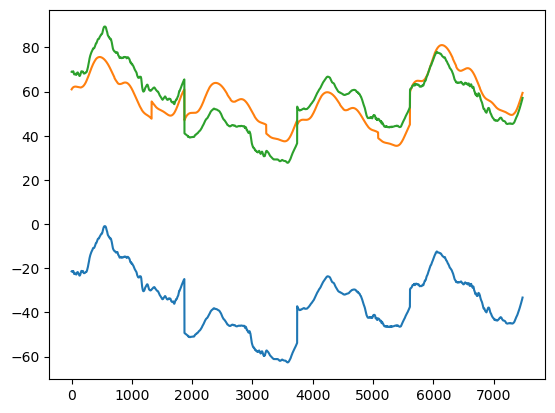

<xarray.Variable (observer: 1, sv: 5, time: 84170)>
array([[[-21.42844171, -21.42781874, -21.43728703, ..., -24.86956407,
         -24.87735193, -24.8789703 ],
        [-49.23558991, -49.23504321, -49.23548561, ..., -53.77494468,
         -53.76866131, -53.7656995 ],
        [-37.19777505, -37.2059644 , -37.20516885, ..., -37.44072664,
         -37.44348353, -37.44336937],
        [-11.91881018, -11.89943994, -11.87629077, ..., -51.35534107,
         -51.33570637, -51.3449691 ],
        [-29.60656196, -29.61434801, -29.60847032, ..., -33.24560224,
         -33.24089035, -33.22968434]]])
Attributes:
    long_name:  Total Electron Content 
    units:      TECU
    var_desc:   bi_frequency slant TEC
    smth_type:  Carrier_phase smoothing Pseudo_range TEC 
<xarray.Variable (observer: 1, sv: 5, time: 84170)>
array([[[68.95252741, 68.95315039, 68.9436821 , ..., 65.51140505,
         65.5036172 , 65.50199883],
        [41.14537922, 41.14592591, 41.14548352, ..., 36.60602445,
         36.6123

In [358]:
# obs = {}

# obs['date'    ]    = datetime.date(year = 2023, 
#                                    month = 9, 
#                                    day = 23 )
# obs['interval']    = 15

# obs['sample_rate'] = '01s'

# obs['year'    ]    = obs['date'].strftime("%y") 
# obs['doy'     ]    = obs['date'].strftime("%j") 

# obs['hour'    ]    = {f'{key:02}':chr(key+97) 
#                       for key in range(0,24)}

# obs['minute'   ]   = {f'{key:02}':f'{key:02}' 
#                       for key in range(0,60,obs['interval'])}

# obs['doy'] = '210'   #test /run/media/echoo/TOSHIBA EXT/210

# src_dir = Path(f"/run/media/echoo/TOSHIBA EXT/GNSS/2022/{obs['doy']}")

# data_dir = mkdir_for_srcdir(src_dir, ['TGD','RNX','TEC','PLOT'])

# info_path = new_obs_info_txt( src_dir.parent, ['qcinfo',
#                                                'RNX_update',
#                                                'RNX_rename'] )

# freqc = {'E2I' :1561.098 * const.mega, 
#          'E6I' :1268.52  * const.mega, 
#          'E5bI':1207.14  * const.mega }

# #     C01 - 地球静止轨道140.0°E，高度35807×35782公里，倾角1.6°
# #     C02 - 地球静止轨道84.07°E，高度35803×35783公里，倾角1.7°
# #     C03 - 地球静止轨道110.45°E，高度35854.3×35885.9公里，倾角1.7°
# #     C04 - 地球静止轨道159.98°E，高度35815×35772公里，倾角0.6°
# #     C05 - 地球静止轨道58.71°E，高度35801×35786公里，倾角1.4°
# # 东经58.75度、80度、110.5度、140度和160度
# # GEO1. 140°E. GEO2. 80°E. GEO3. 110. 5°E. GEO4. 160°E. GEO5. 58. 75°E
# H_orbit  = 35786 * const.kilo
# H_ionos = 400 * const.kilo

# # print(H_orbit)

# sat_llas = {'C01':[140.0 , 0, H_orbit], 
#             'C02':[80.07 , 0, H_orbit],
#             'C03':[110.45, 0, H_orbit],
#             'C04':[159.98, 0, H_orbit],
#             'C05':[58.71 , 0, H_orbit]}


# # info_path    # test

# count       = 1
# RNX_file    = Path(f'{src_dir}/RNX/GSMA00CHN_R_20222100000_01D_01S_CO.rnx')

# ###
# oVar        = grnx.load(RNX_file, fast = False)

# obs_name    = RNX_file.stem[0:4]
# sample_rate = oVar.interval   
# time_system = oVar.time_system
# rxmodel     = oVar.rxmodel 
# DCBs_step   = 45

# IPP_zenith, IPP_lla = {prn:project_sTEC_to_vTEC(oVar.position, 
#                                                 sat_llas[prn], 
#                                                 H_orbit,
#                                                 H_ionos
#                                                )[0]
#                        for prn in oVar.sv.values},            \
#                       {prn:project_sTEC_to_vTEC(oVar.position, 
#                                                 sat_llas[prn], 
#                                                 H_orbit,
#                                                 H_ionos
#                                                )[1]
#                        for prn in oVar.sv.values}

# TEC_obser  = xr.Dataset()
# init_sv = True

# for prn in oVar.sv.values:

#     lon     = IPP_lla[prn][0]
#     lat     = IPP_lla[prn][1]
#     zenith  = IPP_zenith[prn]

#     print(f'\n{count:3d}  {obs_name} - {prn} : {sat_llas[prn]}')

#     try:
#         sTECs, combination = cal_TECs_of_svs(oVar,
#                                              prn, 
#                                              freqc
#                                             )

#     except:
#         print(f'      BDS - {prn} : '
#               f'calculate TEC failed. \n')
#     else:
#         print(f'      BDS - {prn} : '
#               f'calculate TEC successfully. \n')

#     try:
#         TEC = struct_TECs_of_stations(sTECs      , 
#                                       lon        , lat        , zenith, 
#                                       obs_name   , prn        , 
#                                       sample_rate,
#                                       time_system, rxmodel, combination)

#         del sTECs

#         TEC, TEC_obser = TEC_obser, TEC

#         if not init_sv:
#             TEC_obser = xr.concat([TEC, TEC_obser], dim = 'sv')

#         init_sv = False
#         del TEC  

#     except:
#         print(f'      BDS - {prn} : '
#               f'concat TEC failed. \n')
#     else:
#         print(f'      BDS - {prn} : '
#               f'concat TEC successfully. \n')
        
# try:
#     DCBs = cal_sysm_DCBs_of_station(TEC_obser   , 
#                                     oVar.position, 
#                                     DCBs_step    , 
#                                     H_ionos      , 
#                                    )
    
#     while(DCBs == None):
#         DCBs_step *= 2
#         DCBs = cal_sysm_DCBs_of_station(TEC_obser   , 
#                                         oVar.position, 
#                                         DCBs_step    , 
#                                         H_ionos      , 
#                                        )
#         if DCBs_step > 86400 / 17:
#             DCBs = 0.0
#             print(f'\n{count:3d}  {obs_name} - ALL : '
#                   f'calculate DCBs (satellite plus receiver) failed. \n      ')

            
#     TEC_obser.variables['sTEC_smth'].data         -= DCBs
    
#     TEC_obser['DCBs']                              = (('observer', ), [DCBs]) 
#     TEC_obser.variables['DCBs'].attrs['long_name'] = 'Differential Code Bias'
#     TEC_obser.variables['DCBs'].attrs['units'    ] = 'TECU'
#     TEC_obser.variables['DCBs'].attrs['system'   ] = 'SPR (satellite plus receiver)' 
    
#     print(f'\n{count:3d}  {obs_name} - ALL : '
#           f'calculate DCBs (satellite plus receiver) successfully. \n      ')
# except:
#     print(f'\n{count:3d}  {obs_name} - ALL : '
#           f'calculate DCBs (satellite plus receiver) failed. \n      ')
    
# if 'observer' in TEC_obser.coords:
#     nc_file_obser = Path(f"{data_dir['TEC']}/"
#                          f"TEC_{obs_name}_{obs['doy']}_{obs['sample_rate']}_{obs['year']}.nc")
    
#     TEC_obser.to_netcdf(nc_file_obser)

#     init_obser = False

# # del TEC_obser
# print(f'\n{count:3d}  {obs_name} - ALL : '
#       f'concat TEC successfully. \n')

